In [1]:
import os
import numpy as np
import numba
import numba.cffi_support
import importlib
import sunode
from sunode import lambdify
import sympy as sy
import matplotlib.pyplot as plt

In [2]:
state_dtype = np.dtype([('X', (np.float64, ())), ('S', (np.float64, ()))], align=True)
state_ndtype = numba.from_dtype(state_dtype)

In [3]:
user_dtype = np.dtype(
    [
        ('deriv_params', [
            ('mu_max', (np.float64, ())),
            ('Y_XS', (np.float64, ())),
        ]),
        ('params', [
            ('K_S', (np.float64, ())),
        ]),
    ],
    align=True
)
user_ndtype = numba.from_dtype(user_dtype)
user_ndtype

user_ndtype_p = numba.types.CPointer(user_ndtype)
user_data = np.zeros((1,), dtype=user_dtype)[0]
user_data['deriv_params']['mu_max'] = 0.4
user_data['deriv_params']['Y_XS'] = 0.5
user_data['params']['K_S'] = 0.02
user_data

((0.4, 0.5), (0.02,))

In [4]:
# log scale
@numba.njit
def rhs(out_state, t, state, deriv_params, params, section):
    mu_max = deriv_params.mu_max
    Y_XS = deriv_params.Y_XS
    K_S = params.K_S

    dXdt = mu_max / (np.exp(state.S) + K_S)
    out_state.S = -1 / Y_XS * dXdt * np.exp(state.X)
    out_state.X = dXdt * np.exp(state.S)
    return 0

In [5]:
@numba.njit
def rhs(out_state, t, state, deriv_params, params, section):
    mu_max = deriv_params.mu_max
    Y_XS = deriv_params.Y_XS
    K_S = params.K_S

    dXdt = mu_max * state.X * state.S / (state.S + K_S)
    out_state.S = -1 / Y_XS * dXdt
    out_state.X = dXdt
    return 0

In [6]:
def sympy_func(t, state, grad_params, params, section):
    S = state['S']
    X = state['X']

    return {
        'S': 0,
        'X': 0,
    }

In [7]:
def make_numba(sympy_func, arg_dtypes, out_dtypes):
    ...

In [8]:
(
    solver()
    .coords({
        'time': np.linspace(0, 10)
    })
    .states({
        'S': (),
        'X': (),
    })
    .deriv_params({
        'mu_max': (),
        'Y_XS': (),
    })
    .params({
        'K_S': (),
    })
    .rhs(numba_rhs, backend='numba')
)

NameError: name 'solver' is not defined

In [9]:
ffi = sunode._cvodes.ffi
lib = sunode._cvodes.lib

In [10]:
numba.cffi_support.register_module(sunode._cvodes)
numba.cffi_support.register_type(
    ffi.typeof('N_Vector').item,
    numba.types.Opaque('N_Vector'))
numba.cffi_support.register_type(
    ffi.typeof('SUNMatrix').item,
    numba.types.Opaque('SUNMatrix'))

In [11]:
ndim = 2
y0 = sunode.empty_vector(ndim)
y0.data[:] = 0

In [12]:
abstol = sunode.empty_vector(ndim)
abstol.data[:] = [1e-8, 1e-8]
reltol = 1e-8

In [13]:
ode = lib.CVodeCreate(lib.CV_BDF)
#ode = lib.CVodeCreate(lib.CV_ADAMS)

In [14]:
user_data_p = ffi.cast('void *', ffi.addressof(ffi.from_buffer(user_data.data)))

In [15]:
N_VGetArrayPointer_Serial = lib.N_VGetArrayPointer_Serial

func_type = numba.cffi_support.map_type(ffi.typeof('CVRhsFn'))
func_type = func_type.return_type(*(func_type.args[:-1] + (user_ndtype_p,)))
func_type

@numba.cfunc(func_type)
def rhs_wrapper(t, y_, out_, user_data_):
    y_ptr = N_VGetArrayPointer_Serial(y_)
    out_ptr = N_VGetArrayPointer_Serial(out_)
    y = numba.carray(y_ptr, (ndim,))
    out = numba.carray(out_ptr, (ndim,))
    
    y = y.view(state_dtype)[0]
    out = out.view(state_dtype)[0]
    
    user_data = numba.carray(user_data_, (1,))[0]
    #grad_vars = user_data.grad_vars
    #p = user_data.p
    section = 0
    
    return rhs(out, t, y, user_data.deriv_params, user_data.params, section)
    #return rhs(t, y, out, user_data)

In [16]:
print(lib.CVodeInit(ode, rhs_wrapper.cffi, 0, y0.c_ptr))
#lib.CVodeSVtolerances(ode, reltol, abstol.c_ptr)
lib.CVodeSStolerances(ode, 1e-8, 1e-8)

0


0

In [17]:
A = lib.SUNDenseMatrix(ndim, ndim)

In [18]:
linsolver = lib.SUNLinSol_Dense(y0.c_ptr, A)

In [19]:
lib.CVodeSetLinearSolver(ode, linsolver, A)

0

In [20]:
#lib.CVodeSetJacFn(ode, Jac.cffi)

In [21]:
lib.CVodeSetUserData(ode, user_data_p)

0

In [22]:
nparam = 2

In [23]:
yS = lib.N_VCloneVectorArray(nparam, y0.c_ptr)

In [24]:
vecs = [sunode.basic.Vector(yS[i]) for i in range(nparam)]
for vec in vecs:
    vec.data[:] = 0
np.array([vec.data for vec in vecs])

array([[0., 0.],
       [0., 0.]])

In [188]:
func_type = numba.cffi_support.map_type(ffi.typeof('CVSensRhsFn'))
args = list(func_type.args)
args[-3] = user_ndtype_p
func_type = func_type.return_type(*args)
func_type

@numba.cfunc(func_type)
def sens_rhs(n_params, t, y_, ydot_, yS_, out_, user_data_, tmp1_, tmp2_):
    y_ptr = N_VGetArrayPointer_Serial(y_)
    y = numba.carray(y_ptr, (ndim,))
    y_dot_ptr = N_VGetArrayPointer_Serial(ydot_)
    ydot = numba.carray(y_dot_ptr, (ndim,))
    
    out = []
    for i in range(n_params):
        out_i_ptr = N_VGetArrayPointer_Serial(out_[i])
        out_i = numba.carray(out_i_ptr, (ndim,))
        out.append(out_i)

    yS = []
    for i in range(n_params):
        yS_i_ptr = N_VGetArrayPointer_Serial(yS_[i])
        yS_i = numba.carray(yS_i_ptr, (ndim,))
        yS.append(yS_i)
        
    user_data = numba.carray(user_data_, (1,))[0]
    p = user_data.p
    
    df_dp = df_dp_comp((), p.reshape((-1, 1)), y.reshape((-1, 1)))

    for i in range(n_params):
        s = yS[i]
        ySdot = out[i]

        jacobian_prod(t, s, y, None, ySdot, user_data)
        ySdot[:] += df_dp[:, i]
    
    return 0

In [25]:
#assert 0 == lib.CVodeSensInit(ode, nparam, lib.CV_STAGGERED, sens_rhs.cffi, yS)

#assert 0 == lib.CVodeSensInit(ode, nparam, lib.CV_STAGGERED, ffi.cast('void*', 0), yS)
#assert 0 == lib.CVodeSensEEtolerances(ode)
#assert 0 == lib.CVodeSetSensErrCon(ode, 1)

In [26]:
#pbar = np.ones(nparam)
#NULL_D = ffi.cast('double *', 0)
#NULL_I = ffi.cast('int *', 0)
#pbar_p = ffi.cast('double *', ffi.addressof(ffi.from_buffer(pbar.data)))
#p = ffi.cast('double *', ffi.addressof(ffi.from_buffer(user_data['deriv_params'])))

In [27]:
#lib.CVodeSetSensParams(ode, p, pbar_p, NULL_I)

In [28]:
time_p = ffi.new('double*')
time_p[0] = 0.

In [42]:
tvals = np.linspace(0, 20, 200)
y_vals = []
sens_vals = []

#user_data['p'][...] = [0.4, 0.02, 0.5]

In [43]:
#start = np.log([0.05, 20])
start = np.array([0.05, 20])
y_vals = np.empty((len(tvals), len(start)))

In [44]:
#%%timeit
CVodeReInit = lib.CVodeReInit
CVode = lib.CVode
CVodeGetSens = lib.CVodeGetSens
y0_ptr = y0.c_ptr
y0_data = y0.data
sens_data = tuple(vec.data for vec in vecs)

@numba.njit()
def solve(ode, y0_ptr, time_p, y0_data, start, t0, y_vals):
    #y_vals.clear()
    #sens_vals.clear()

    y0_data[:] = start
    #y0.data[:] = np.log(y0.data)
    #for vec in vecs:
    #    vec.data[:] = 0
    #current_time[0] = t0

    CVodeReInit(ode, t0, y0_ptr)
    for i, t in enumerate(tvals):
        retval = -1
        while retval == -1:
            retval = CVode(ode, t, y0_ptr, time_p, lib.CV_NORMAL)
        #y_vals.append(y0_data.copy())
        y_vals[i, :] = y0_data
        CVodeGetSens(ode, time_p, yS)
        for 
        #sens_vals.append(np.array([vec.data.copy() for vec in vecs]).T)

solve(ode, y0_ptr, time_p, y0_data, start, 0., y_vals)

In [58]:
import xarray as xr
import pandas as pd

In [54]:
%timeit xr.DataArray(y_vals)

12.6 µs ± 37.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [70]:
data = y_vals.view(state_dtype)[:, 0]

In [80]:
%timeit pd.DataFrame.from_records(y_vals.view(state_dtype)[:, 0])

255 µs ± 465 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [88]:
state_dtype.fields.keys()

dict_keys(['X', 'S'])

In [105]:
state_dtype['X'].fields

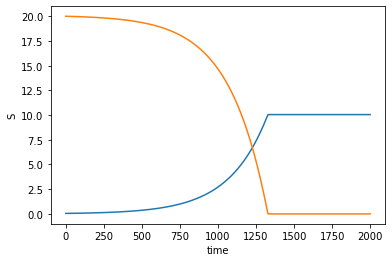

In [101]:
data_xr = xr.Dataset({name: (('time'), data[name]) for name in state_dtype.fields})
xr.Dataset({name: (('time'), data[name]) for name in state_dtype.fields}).X.plot.line()
xr.Dataset({name: (('time'), data[name]) for name in state_dtype.fields}).S.plot.line()

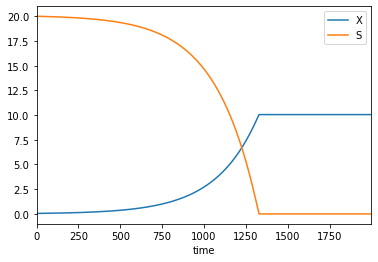

In [108]:
data_xr.to_dataframe().plot()

In [103]:
data_xr

<xarray.Dataset>
Dimensions:  (time: 2000)
Dimensions without coordinates: time
Data variables:
    X        (time) float64 0.05 0.0502 0.0504 0.0506 ... 10.05 10.05 10.05
    S        (time) float64 20.0 20.0 20.0 ... -8.184e-18 -8.18e-18 -8.176e-18

In [89]:
%timeit xr.Dataset({name: data[name] for name in state_dtype.fields})

228 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
%%prun -stime
for _ in range(1000):
    pd.DataFrame.from_records(y_vals.view(state_dtype)[:, 0]).to_xarray()

         2827003 function calls (2773003 primitive calls) in 1.715 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   369000    0.082    0.000    0.127    0.000 {built-in method builtins.isinstance}
   118000    0.064    0.000    0.064    0.000 {built-in method builtins.hasattr}
     4000    0.046    0.000    0.305    0.000 alignment.py:340(deep_align)
     7000    0.039    0.000    0.256    0.000 merge.py:227(collect_variables_and_indexes)
     4000    0.033    0.000    0.865    0.000 merge.py:490(merge_core)
175000/133000    0.032    0.000    0.044    0.000 {built-in method builtins.len}
15000/11000    0.031    0.000    0.128    0.000 {built-in method numpy.array}
    28000    0.029    0.000    0.034    0.000 typing.py:806(__new__)
    62000    0.028    0.000    0.040    0.000 <frozen importlib._bootstrap>:416(parent)
     4000    0.026    0.000    0.161    0.000 alignment.py:61(align)
    80000    0.021    0.000    0.029

In [61]:
user_data.reshape((1,))

array([((0.4, 0.5), (0.02,))],
      dtype={'names':['deriv_params','params'], 'formats':[[('mu_max', '<f8'), ('Y_XS', '<f8')],[('K_S', '<f8')]], 'offsets':[0,16], 'itemsize':24, 'aligned':True})

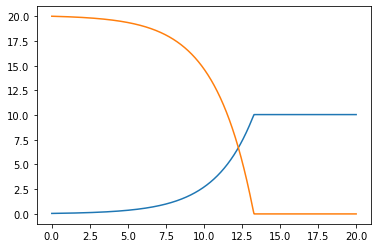

In [46]:
plt.plot(tvals, y_vals[:, 0])
plt.plot(tvals, y_vals[:, 1])

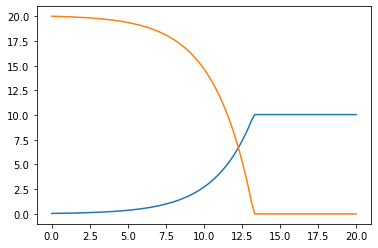

In [30]:
plt.plot(tvals, np.exp(np.array(y_vals)[:, 0]))
plt.plot(tvals, np.exp(np.array(y_vals)[:, 1]))

In [31]:
plt.plot(tvals, np.array(sens_vals)[:, 0, 0])
plt.plot(tvals, np.array(sens_vals)[:, 0, 1])
plt.plot(tvals, np.array(sens_vals)[:, 0, 2])

IndexError: too many indices for array

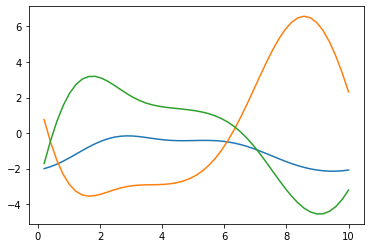

In [97]:
plt.plot(tvals, np.array(sens_vals)[:, 1, 0])
plt.plot(tvals, np.array(sens_vals)[:, 1, 1])
plt.plot(tvals, np.array(sens_vals)[:, 1, 2])

In [98]:
num_evals_p = ffi.new('long*')
num_evals_p[0] = 0

In [99]:
lib.CVodeGetNumRhsEvals(ode, num_evals_p)
num_evals_p[0]

331

In [100]:
lib.CVodeGetNumSteps(ode, num_evals_p)
num_evals_p[0]

158

In [101]:
time_p[0]

10.0

In [102]:
from scipy import integrate

In [103]:
def rhs_(t, y):
    out = np.empty_like(y)
    assert rhs(t, y, out, user_data) == 0
    return out

In [104]:
def jac_(t, y):
    out = np.empty((ndim, ndim))
    assert jacobian(t, y, None, out, user_data) == 0
    return out

In [105]:
from scipy import integrate

In [106]:
%%timeit
out = integrate.solve_ivp(
    rhs_,
    jac=jac_,
    t_span=(0, tvals.max()),
    t_eval=tvals, y0=np.array([0.5, 0.6]), method='BDF',
    rtol=reltol, atol=abstol.data.copy())

46.6 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
out = integrate.solve_ivp(
    rhs_,
    jac=jac_,
    t_span=(0, tvals.max()),
    t_eval=tvals, y0=np.array([0.5, 0.6]), method='BDF',
    rtol=reltol, atol=abstol.data.copy())

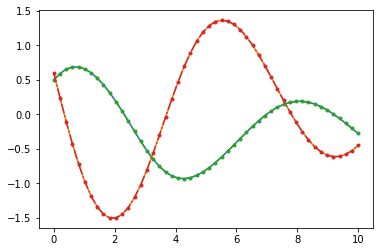

In [108]:
plt.plot(tvals, out.y[0, :])
plt.plot(tvals, out.y[1, :])

plt.plot(tvals, np.array(y_vals)[:, 0], '.-.')
plt.plot(tvals, np.array(y_vals)[:, 1], '.-.')

In [71]:
out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 414
     njev: 1
      nlu: 36
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.20408163,  0.40816327,  0.6122449 ,  0.81632653,
        1.02040816,  1.2244898 ,  1.42857143,  1.63265306,  1.83673469,
        2.04081633,  2.24489796,  2.44897959,  2.65306122,  2.85714286,
        3.06122449,  3.26530612,  3.46938776,  3.67346939,  3.87755102,
        4.08163265,  4.28571429,  4.48979592,  4.69387755,  4.89795918,
        5.10204082,  5.30612245,  5.51020408,  5.71428571,  5.91836735,
        6.12244898,  6.32653061,  6.53061224,  6.73469388,  6.93877551,
        7.14285714,  7.34693878,  7.55102041,  7.75510204,  7.95918367,
        8.16326531,  8.36734694,  8.57142857,  8.7755102 ,  8.97959184,
        9.18367347,  9.3877551 ,  9.59183673,  9.79591837, 10.        ])
 t_events: None
        y: array([[ 0.5       ,  0.59330775,  0.6558635 ,  0.68691887,  0.68730437,